In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Set plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## 1. Load Data
Loading the preprocessed dataset.

In [2]:
# Load data with MultiIndex (timestamp, unique_id)
df = pd.read_csv('../datasets/m5_walmart_hobbies_daily.csv', parse_dates=['timestamp'])
df.set_index(['timestamp', 'unique_id'], inplace=True)

print("Dataset Shape:", df.shape)
print("\nUnique Items:", df.index.get_level_values('unique_id').unique().tolist())
print("\nHead:")
print(df.head())
print("\nInfo:")
print(df.info())

Dataset Shape: (9565, 10)

Unique Items: ['HOBBIES_1_242', 'HOBBIES_2_071', 'HOBBIES_2_108', 'HOBBIES_2_109', 'HOBBIES_2_123']

Head:
                          sales_count event_name_1 event_type_1  wday  month  \
timestamp  unique_id                                                           
2011-01-29 HOBBIES_1_242            7      NoEvent      NoEvent     1      1   
           HOBBIES_2_071            0      NoEvent      NoEvent     1      1   
           HOBBIES_2_108            0      NoEvent      NoEvent     1      1   
           HOBBIES_2_109            0      NoEvent      NoEvent     1      1   
           HOBBIES_2_123            0      NoEvent      NoEvent     1      1   

                          year  snap_CA  snap_TX  snap_WI  snap_total  
timestamp  unique_id                                                   
2011-01-29 HOBBIES_1_242  2011        0        0        0           0  
           HOBBIES_2_071  2011        0        0        0           0  
           HOBBIE

## 2. Time Series Plot
Visualizing the Sales over time.

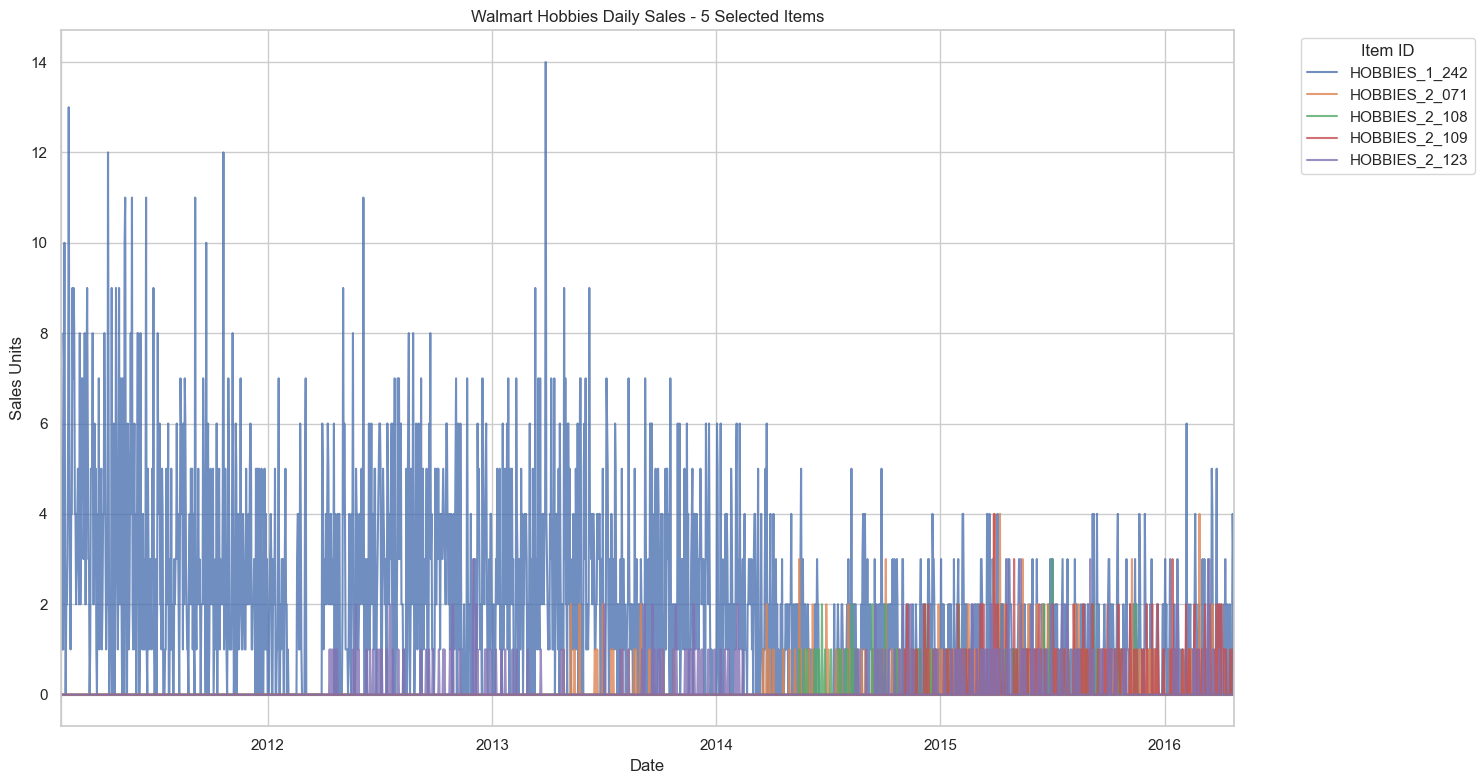

In [3]:
# Pivot for easier plotting of multiple series
df_pivot = df.reset_index().pivot(index='timestamp', columns='unique_id', values='sales_count')

plt.figure(figsize=(15, 8))
df_pivot.plot(ax=plt.gca(), alpha=0.8, linewidth=1.5)
plt.title('Walmart Hobbies Daily Sales - 5 Selected Items')
plt.xlabel('Date')
plt.ylabel('Sales Units')
plt.legend(title='Item ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## 3. Decomposition
Decomposing the time series into Trend, Seasonal, and Residual components for **all items**.

**Why does the Seasonality look like a solid block?**
Because we have several years of daily data (~1900 days) and a short weekly cycle (7 days), the seasonal pattern repeats over 270 times. When squeezed into a single plot, these rapid oscillations merge into a solid block. To see the actual pattern, we will include a **zoomed-in plot** of the last 90 days.

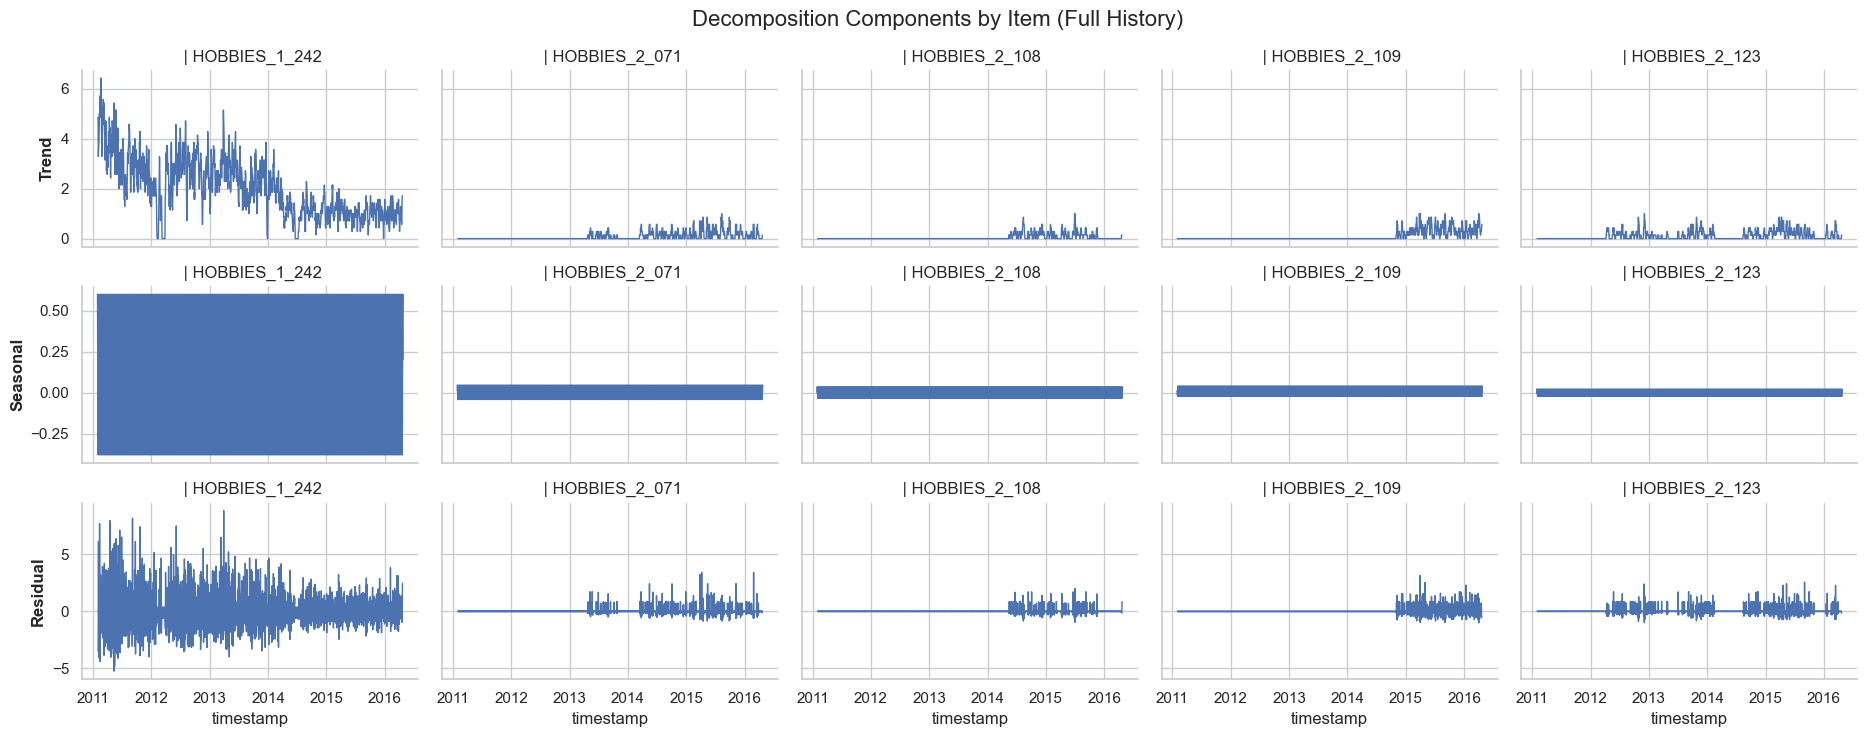


Zooming in on the Seasonal Component (Last 90 Days) to reveal the weekly pattern:


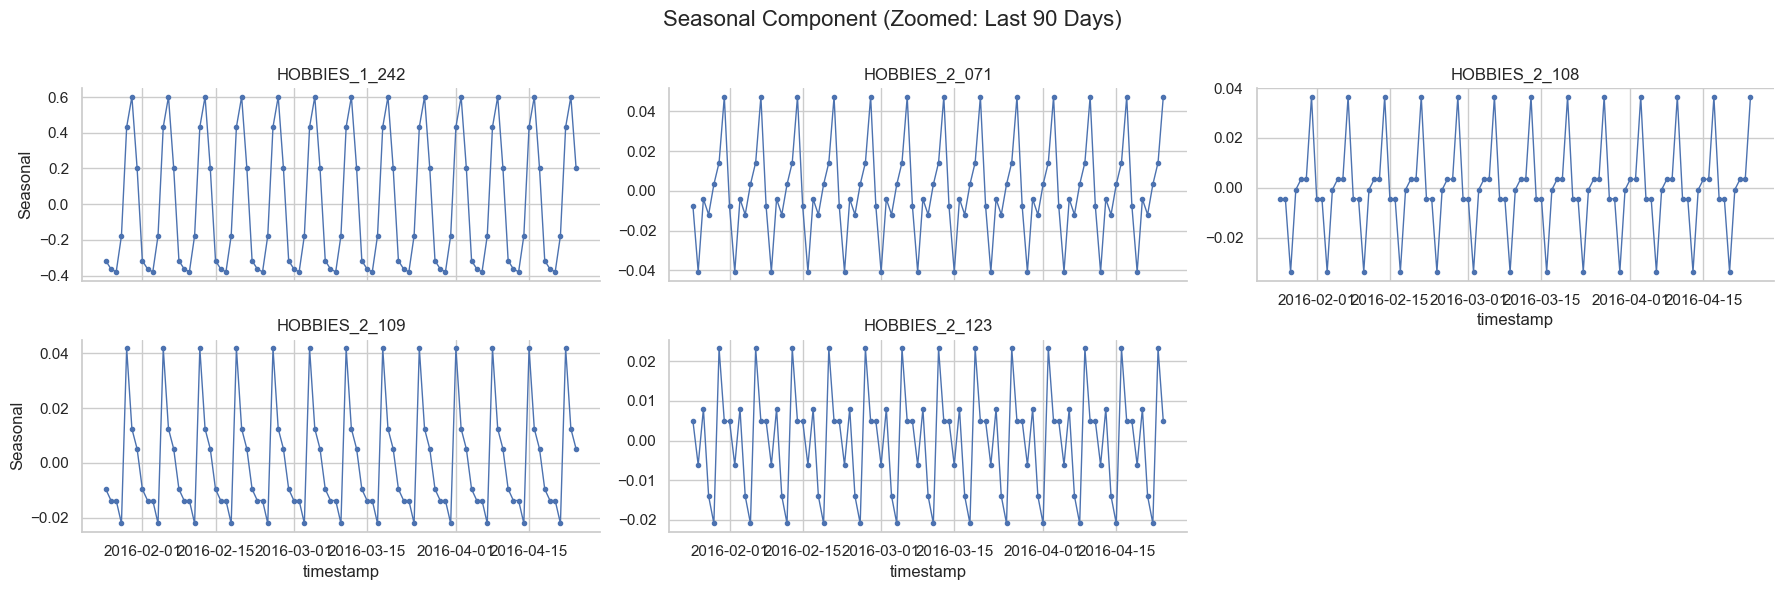

In [4]:
# Decompose all items and store components
decomp_results = []

for item in df.index.get_level_values('unique_id').unique():
    series = df.xs(item, level='unique_id')['sales_count']
    # period=7 for daily data (weekly seasonality)
    res = seasonal_decompose(series, model='additive', period=7)
    
    # Create a temporary dataframe for this item's decomposition
    temp_df = pd.DataFrame({
        'timestamp': series.index,
        'unique_id': item,
        'Trend': res.trend,
        'Seasonal': res.seasonal,
        'Residual': res.resid
    })
    decomp_results.append(temp_df)

df_decomp = pd.concat(decomp_results)

# Melt for FacetGrid
df_decomp_long = df_decomp.melt(id_vars=['timestamp', 'unique_id'], 
                                value_vars=['Trend', 'Seasonal', 'Residual'], 
                                var_name='Component', value_name='Value')

# Define component order
component_order = ['Trend', 'Seasonal', 'Residual']

# 1. Full Decomposition Plot
g = sns.FacetGrid(df_decomp_long, row='Component', col='unique_id', 
                  row_order=component_order,
                  sharex=True, sharey='row', 
                  height=2.5, aspect=1.5)

g.map(plt.plot, 'timestamp', 'Value', linewidth=1)
g.set_titles(row_template="", col_template="{col_name}")

# Manually set Y-labels
for i, ax_row in enumerate(g.axes):
    ax_row[0].set_ylabel(component_order[i], fontsize=12, fontweight='bold')

plt.subplots_adjust(top=0.9)
g.figure.suptitle('Decomposition Components by Item (Full History)', fontsize=16)
plt.show()

# 2. Zoomed-in Seasonal Plot (Last 90 Days)
# To show that the "solid block" is actually a weekly pattern
print("\nZooming in on the Seasonal Component (Last 90 Days) to reveal the weekly pattern:")
last_date = df_decomp['timestamp'].max()
start_zoom = last_date - pd.Timedelta(days=90)
df_zoom = df_decomp[df_decomp['timestamp'] >= start_zoom]

g_zoom = sns.FacetGrid(df_zoom, col='unique_id', col_wrap=3, height=3, aspect=2, sharey=False)
g_zoom.map(plt.plot, 'timestamp', 'Seasonal', marker='o', markersize=3, linewidth=1)
g_zoom.set_titles("{col_name}")
g_zoom.figure.suptitle('Seasonal Component (Zoomed: Last 90 Days)', fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

## 4. Autocorrelation and Partial Autocorrelation
Checking for serial correlation for **all items** using a grid layout.

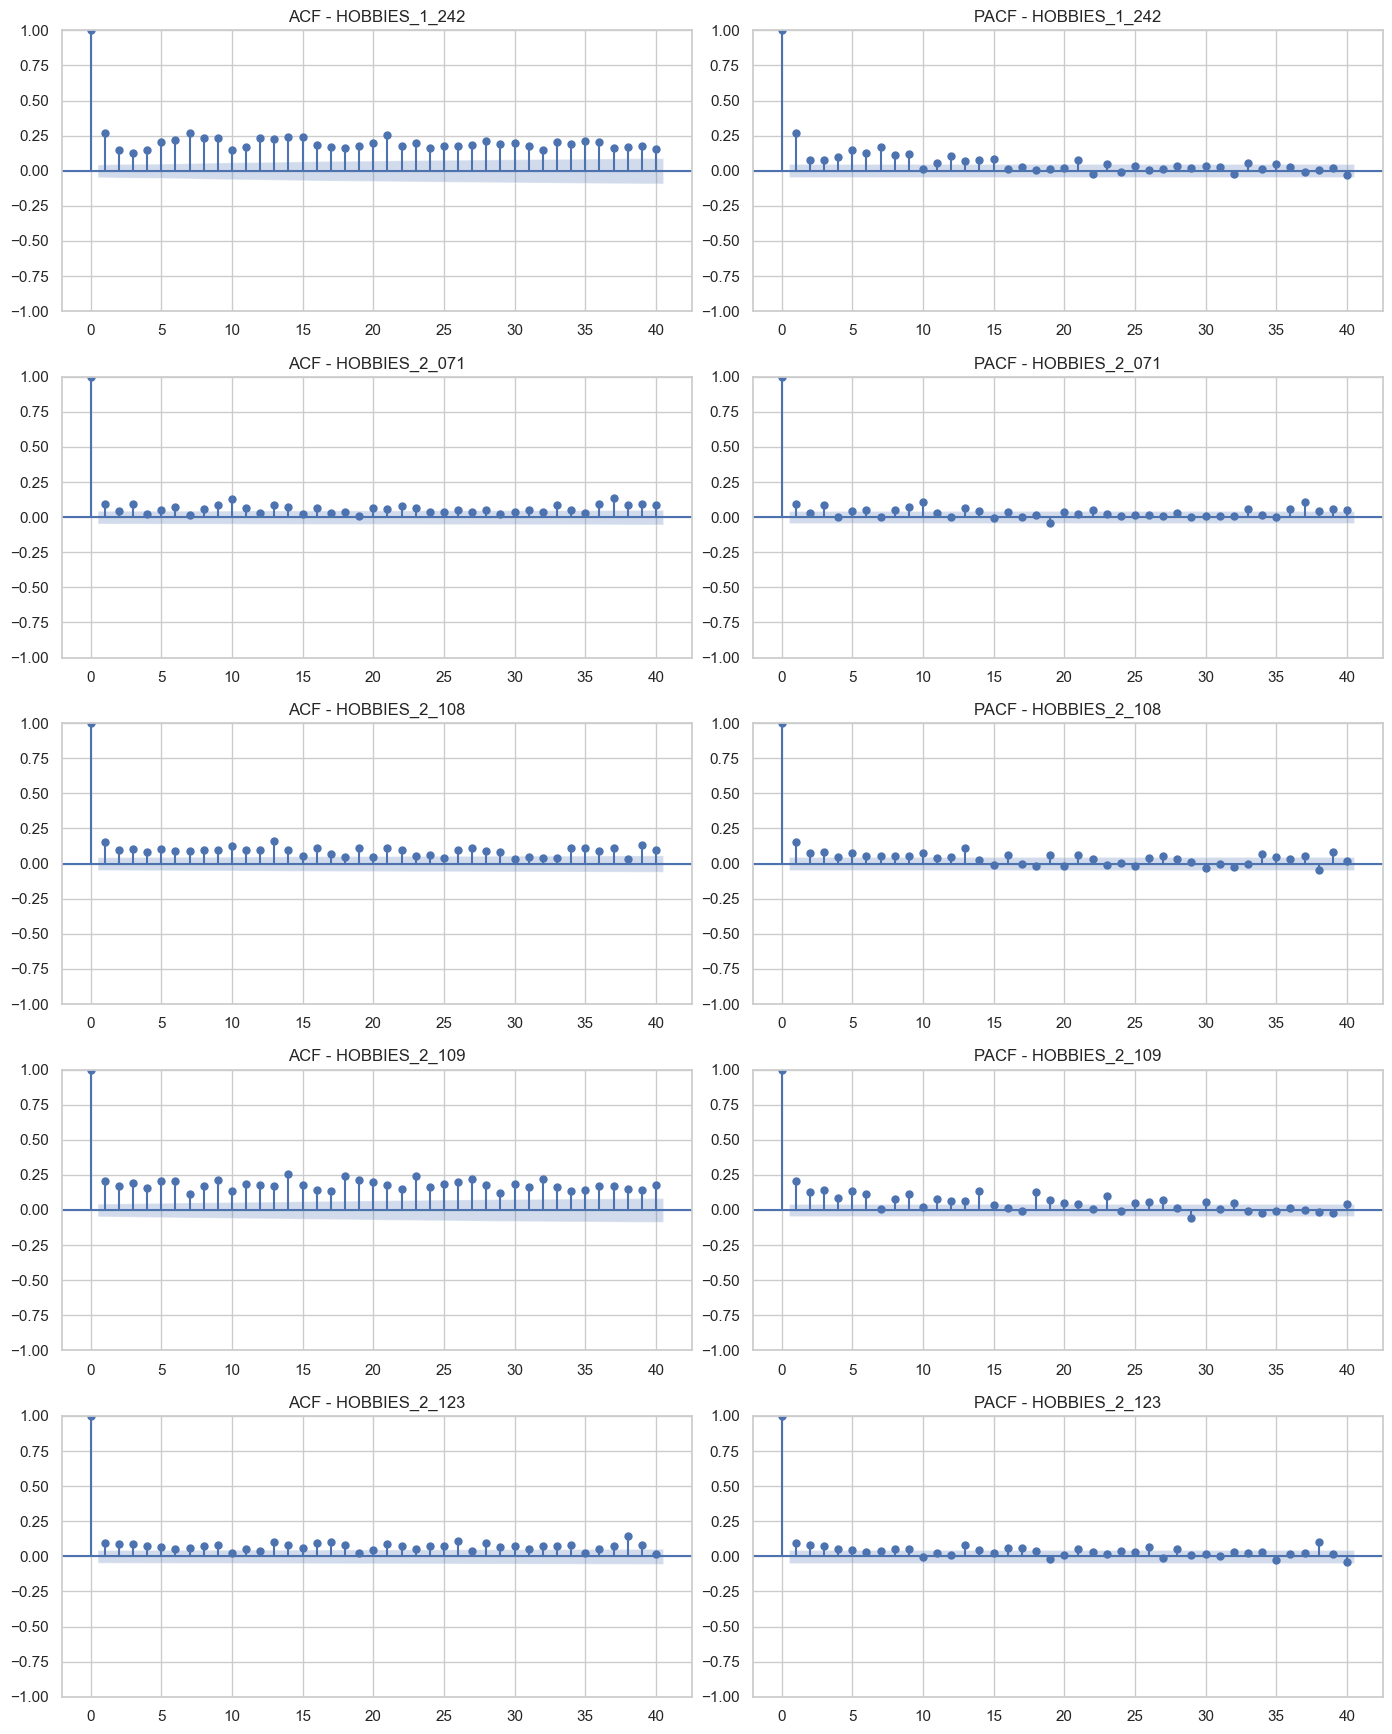

In [5]:
items = df.index.get_level_values('unique_id').unique()
n_items = len(items)

# Create a grid of subplots: Rows = Items, Cols = 2 (ACF, PACF)
fig, axes = plt.subplots(nrows=n_items, ncols=2, figsize=(14, 3.5 * n_items))

for i, item in enumerate(items):
    series = df.xs(item, level='unique_id')['sales_count']
    
    # ACF
    plot_acf(series, ax=axes[i, 0], lags=40, title=f'ACF - {item}')
    
    # PACF
    plot_pacf(series, ax=axes[i, 1], lags=40, method='ywm', title=f'PACF - {item}')

plt.tight_layout()
plt.show()

## 5. Distribution of Data
Checking the distribution of sales.

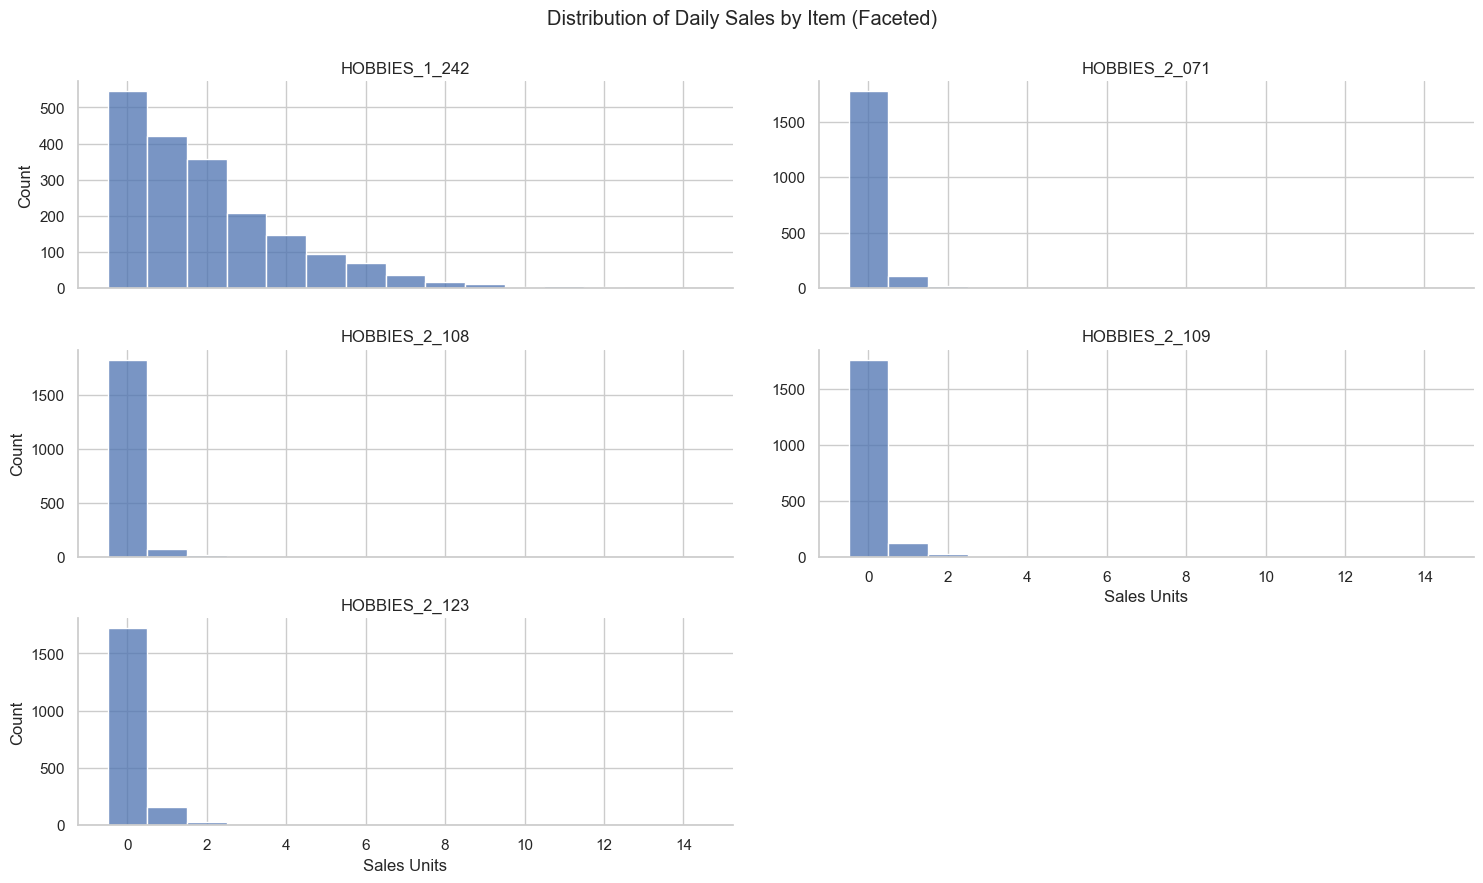

In [6]:
# Improved Distribution Plots
# Faceted Histogram to see each item clearly without overlap
g = sns.FacetGrid(df.reset_index(), col="unique_id", col_wrap=2, sharex=True, sharey=False, height=3, aspect=2.5)
g.map(sns.histplot, "sales_count", discrete=True, kde=False)
g.set_titles("{col_name}")
g.set_axis_labels("Sales Units", "Count")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Distribution of Daily Sales by Item (Faceted)')
plt.show()

## 6. Stationarity Test (ADF Test)
Checking if the time series is stationary for each item.

In [7]:
# Run ADF test for each item
results = []

for item in df.index.get_level_values('unique_id').unique():
    series = df.xs(item, level='unique_id')['sales_count']
    result = adfuller(series)
    
    is_stationary = result[1] < 0.05
    results.append({
        'unique_id': item,
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Stationary': is_stationary
    })

df_adf = pd.DataFrame(results)
print("Augmented Dickey-Fuller Test Results:")
print(df_adf)

Augmented Dickey-Fuller Test Results:
       unique_id  ADF Statistic       p-value  Stationary
0  HOBBIES_1_242      -4.102581  9.590533e-04        True
1  HOBBIES_2_071      -7.909065  3.993185e-12        True
2  HOBBIES_2_108      -5.600722  1.266626e-06        True
3  HOBBIES_2_109      -2.072732  2.556196e-01       False
4  HOBBIES_2_123      -4.869517  3.996560e-05        True


## 7. Differencing (if non-stationary)
We automatically select a non-stationary item (based on the ADF test above) and apply first differencing to stabilize the mean. If all items are stationary, we demonstrate differencing on the first item.

Selected non-stationary item for differencing: HOBBIES_2_109


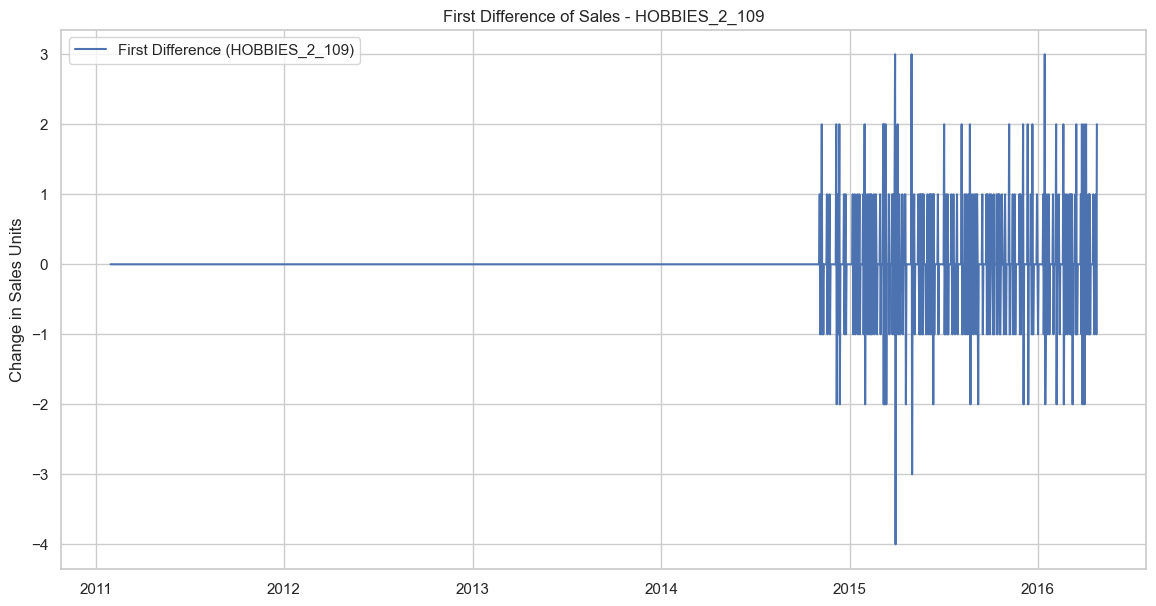

ADF Statistic (Diff - HOBBIES_2_109): -16.57004791164956
p-value (Diff - HOBBIES_2_109): 1.8738012581232508e-29


In [8]:
# Identify a non-stationary item for differencing
non_stationary_items = df_adf[df_adf['Stationary'] == False]['unique_id'].tolist()

if non_stationary_items:
    target_diff_item = non_stationary_items[0]
    print(f"Selected non-stationary item for differencing: {target_diff_item}")
else:
    target_diff_item = df.index.get_level_values('unique_id').unique()[0]
    print(f"All items are stationary. Using default item: {target_diff_item}")

# Select the series
series_to_diff = df.xs(target_diff_item, level='unique_id')['sales_count']

# Apply differencing
series_diff = series_to_diff.diff().dropna()

plt.figure(figsize=(14, 7))
plt.plot(series_diff.index, series_diff, label=f'First Difference ({target_diff_item})')
plt.title(f'First Difference of Sales - {target_diff_item}')
plt.ylabel('Change in Sales Units')
plt.legend()
plt.show()

# Check stationarity of differenced data
result_diff = adfuller(series_diff)
print(f'ADF Statistic (Diff - {target_diff_item}):', result_diff[0])
print(f'p-value (Diff - {target_diff_item}):', result_diff[1])